## Data Preparation For Teams' Rankings Prediction

In this notebook we will prepare a dataset for the Team´s Ranking Prediction task

#### Load Dependencies

In [17]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from data_scripts import _store_data as sd
sd.load_data(Path("../data"))

#### Playoff Columns Transformation and Win Percentage

In the `prepare_basic_columns` function, we convert all playoff-related indicators and round results into **binary variables**, since each of these fields naturally represents only two possible states (e.g., made playoffs vs. did not, won a round vs. lost). Converting them to binary ensures consistency, simplifies modeling, and prevents unnecessary categorical complexity.

The function also creates two new features, **`prev_win_pct`**, which captures the team’s **win percentage from the previous season**, and **`made_playofss`** which captures the team’s **playoffs participation from the previous season**. This provides the model with meaningful historical context about overall team strength while avoiding leakage from the test year.

Together, these transformations make the dataset cleaner, more structured, and better suited for predictive modeling.


In [18]:
def prepare_basic_columns(teams_df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and prepare basic team columns.
    
    - Converts playoff indicators to binary
    - Converts playoff round results to binary
    - Calculates win percentage
    - Encodes conference IDs
    """
    df = teams_df.copy()
    
    df['playoff'] = df['playoff'].apply(lambda x: 1 if x == 'Y' else 0)
    
    for col in ['firstRound', 'semis', 'finals']:
        df[col] = df[col].apply(
            lambda x: 1 if x == 'W' else (0 if x == 'L' else 0)
        )
    df['win_pct'] = df['won'] / (df['won'] + df['lost'])
    df.drop(columns=['won', 'lost'], inplace=True)
    df = df.sort_values(['tmID', 'year'])
    df['prev_win_pct'] = df.groupby('tmID')['win_pct'].shift(1)
    df['prev_win_pct'] = df['prev_win_pct'].fillna(0)
    df.drop(columns=['win_pct'], inplace=True)
    
    le = LabelEncoder()
    df['confID'] = le.fit_transform(df['confID'])
    
    playoff_cols = ['playoff', 'firstRound', 'semis', 'finals']
    df[playoff_cols] = df[playoff_cols].astype(int)

    df["made_playoffs"] = df.groupby('tmID')['playoff'].shift(1)
    df["made_playoffs"] = df["made_playoffs"].fillna(0)

    
    return df


#### Delete Unused Columns

In the `drop_unused_columns` function, we remove a set of columns listed in `columns_to_drop` because they do not contribute meaningful information for the predictive task. Since our model relies on **previous performance of the current roster's players**, team-level statistics from the test year are not useful—most teams change players frequently, making those aggregated stats poor indicators of future outcomes.

Additionally, purely categorical fields such as **`arena`**, **`franchID`**, and **`name`** provide no numerical value or predictive signal for performance modeling. 

Columns like **`homeW`**, **`homeL`**, **`awayW`**, **`awayL`**, **`confW`**, and **`confL`** represent different breakdowns of team win–loss records. Since the team's overall win percentage has already been calculated elsewhere, these fields would be redundant and are therefore removed to keep the dataset clean and avoid feature duplication.

By dropping these unused columns, we ensure the dataset focuses only on relevant predictors and avoids noise that could harm model performance.


In [19]:

def drop_unused_columns(teams_df: pd.DataFrame) -> pd.DataFrame:
    """Remove columns not needed for modeling."""
    columns_to_drop = [
        'arena', 'franchID', 'attend', 'GP',
        'homeW', 'homeL', 'awayW', 'awayL',
        'confW', 'confL', 'min', 'name',
        'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb',
        'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts',
        'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb',
        'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts'
    ]

    
    existing_cols = [col for col in columns_to_drop if col in teams_df.columns]
    return teams_df.drop(columns=existing_cols)



#### Entity Matching Between Team and Coach Win Percentage

In the `add_prev_coach_win_pct` function, we perform **entity matching** between teams and coaches using the shared `tmID` identifier. This step links each team to its **current head coach** for the given test year.

Once the correct coach is matched, we calculate the coach’s **career win percentage** from their first coaching year up to (but not including) the test year. This historical win rate is used because a coach’s long-term performance tends to remain stable rather than decline sharply from season to season.

By attaching the coach’s cumulative win percentage to the corresponding team, we provide the model with a meaningful indicator of coaching quality without leaking information from the test year.


In [20]:
def add_prev_coach_win_pct(teams_df: pd.DataFrame, 
                           coaches_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add previous cumulative coach win percentage to team dataframe.
    
    For teams with multiple coaches in a year, averages their win percentages.
    prev_coach_win_pct = career win% up to *previous* season.
    """
    df = coaches_df.copy()
    
    df["games"] = df["won"] + df["lost"]
    df["win_pct"] = df["won"] / df["games"].replace(0, np.nan)
    
    df = df.sort_values(["coachID", "year"])
    
    df["cum_wins"] = df.groupby("coachID")["won"].cumsum() - df["won"]
    df["cum_games"] = df.groupby("coachID")["games"].cumsum() - df["games"]
    
    df["prev_coach_win_pct"] = df["cum_wins"] / df["cum_games"].replace(0, np.nan)
    
    df = df[["coachID", "tmID", "year", "prev_coach_win_pct"]]
    
    df_avg = df.groupby(["tmID", "year"])["prev_coach_win_pct"].mean().reset_index()
    
    teams_df = teams_df.merge(df_avg, on=["tmID", "year"], how="left")
    
    teams_df["prev_coach_win_pct"] = teams_df["prev_coach_win_pct"].fillna(0)
    
    return teams_df



#### Player Performance Score Summary

This code calculates multiple performance metrics for basketball players and adds them to a season-by-season player dataset. It first defines formulas for offensive, defensive, and overall performance using per-game statistics such as points, rebounds, assists, steals, blocks, turnovers, and field-goal percentage.

Using these formulas, the code computes each player's current-year performance metrics and then organizes the data chronologically by player. It then creates historical features by adding previous-season performance values and generating weighted multi-year averages (2-year, 3-year, and 4-year) for overall, offensive, and defensive performance. Missing values for players in their early years are filled with zero to indicate no available history.


In [21]:
def offense_score_per_game(PTS: float, AST: float, FGM: float, 
                          FGA: float, TOV: float, GP: int) -> float:
    """Calculate offensive performance score per game."""
    if GP == 0 or FGA == 0:
        return 0
    FG_percent = FGM / FGA
    return (PTS / GP) + 1.5 * (AST / GP) + 10 * FG_percent - 2 * (TOV / GP)


def defense_score_per_game(REB: float, STL: float, BLK: float, 
                          PF: float, GP: int) -> float:
    """Calculate defensive performance score per game."""
    if GP == 0:
        return 0
    return 1.2 * (REB / GP) + 3 * (STL / GP) + 2 * (BLK / GP) - 1 * (PF / GP)


def overall_performance_per_game(PTS: float, REB: float, AST: float, 
                                STL: float, BLK: float, TOV: float,
                                FGM: float, FGA: float, GP: int) -> float:
    """Calculate overall performance score per game."""
    if GP == 0 or FGA == 0:
        return 0
    FG_percent = FGM / FGA
    return (
        (PTS / GP) +
        (REB / GP) * 1.2 +
        (AST / GP) * 1.5 +
        (STL / GP) * 3 +
        (BLK / GP) * 2 -
        (TOV / GP) * 2 +
        FG_percent * 10
    )

def get_team_rosters(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Get list of players on each team per year.
    
    Filters to stints 0 and 1 to get primary team assignments.
    """
    return (
        players_df[players_df['stint'].isin([0, 1])]
        .groupby(['tmID', 'year'])['playerID']
        .unique()
        .reset_index(name='players')
    )

def add_player_performance(players_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add performance metrics to player dataframe.
    """
    df = players_df.copy()

    # Calculate current performance
    df['Performance'] = df.apply(
        lambda row: overall_performance_per_game(
            row['points'], row['rebounds'], row['assists'], row['steals'],
            row['blocks'], row['turnovers'], row['fgMade'], 
            row['fgAttempted'], row['GP']
        ), axis=1
    )

    df['OffPerformance'] = df.apply(
        lambda row: offense_score_per_game(
            row['points'], row['assists'], row['fgMade'], 
            row['fgAttempted'], row['turnovers'], row['GP']
        ), axis=1
    )

    df['DefPerformance'] = df.apply(
        lambda row: defense_score_per_game(
            row['rebounds'], row['steals'], row['blocks'], 
            row['PF'], row['GP']
        ), axis=1
    )

    df = df.sort_values(['playerID', 'year'])

    # Calculate previous and weighted features
    df['PrevPerformance'] = df.groupby('playerID')['Performance'].shift(1)
    df['PrevOffPerformance'] = df.groupby('playerID')['OffPerformance'].shift(1)
    df['PrevDefPerformance'] = df.groupby('playerID')['DefPerformance'].shift(1)

    weights_dict = {
        '2yr': [0.7, 0.3],
        '3yr': [0.5, 0.3, 0.2],
        '4yr': [0.5, 0.25, 0.15, 0.10]
    }

    hist_features = ['Performance', 'OffPerformance', 'DefPerformance']

    for suffix, weights in weights_dict.items():
        for feat in hist_features:
            df[f"{feat}_weighted_{suffix}"] = sum(
                weights[i] * df.groupby('playerID')[feat].shift(i+1) for i in range(len(weights))
            )
    
    # SET FIRST YEAR TO 0 (NO HISTORY)
    df['PrevPerformance'] = df['PrevPerformance'].fillna(0)
    df['PrevOffPerformance'] = df['PrevOffPerformance'].fillna(0)
    df['PrevDefPerformance'] = df['PrevDefPerformance'].fillna(0)
    
    for suffix in weights_dict.keys():
        df[f"Performance_weighted_{suffix}"] = df[f"Performance_weighted_{suffix}"].fillna(0)
        df[f"OffPerformance_weighted_{suffix}"] = df[f"OffPerformance_weighted_{suffix}"].fillna(0)
        df[f"DefPerformance_weighted_{suffix}"] = df[f"DefPerformance_weighted_{suffix}"].fillna(0)

    # Now drop the current performance columns
    df.drop(columns=['Performance', 'OffPerformance', 'DefPerformance'], inplace=True)

    return df



#### Team-Level Player Performance Aggregation and Standardization

The functions `add_team_player_performance` and `standardize_performance_by_year` work together to compute team-level performance indicators by aggregating the historical performance of individual players.

In `add_team_player_performance`, we first generate each player's current and historical performance metrics using `add_player_performance`. We then identify each team’s roster for every season and merge those players with their respective performance metrics. For each team and year, we compute the **average** of all player performance features—including previous-season stats and weighted multi-year historical scores. These aggregated values represent the collective strength of the roster based on players’ past performance rather than team-level box score stats.

We apply **standardization** so that each season's metrics are scaled relative to the distribution of that year. This ensures that team performance values remain comparable even if league-wide play styles or scoring environments shift over time.




In [22]:
def add_team_player_performance(players_teams_df: pd.DataFrame, 
                                teams_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate team-level aggregated player performance metrics.

    Aggregates individual player performance (including weighted historical features)
    to team level and standardizes metrics by year.
    """
    dfp = add_player_performance(players_teams_df)

    if 'tmID' in dfp.columns:
        dfp = dfp.drop(columns=['tmID'])

    roster = get_team_rosters(players_teams_df)
    exploded = roster.explode('players').rename(columns={'players': 'playerID'})

    merged = exploded.merge(dfp, on=['playerID', 'year'], how='left')

    performance_cols = [
        'PrevPerformance', 'PrevOffPerformance', 'PrevDefPerformance',
        'Performance_weighted_2yr', 'OffPerformance_weighted_2yr', 'DefPerformance_weighted_2yr',
        'Performance_weighted_3yr', 'OffPerformance_weighted_3yr', 'DefPerformance_weighted_3yr',
        'Performance_weighted_4yr', 'OffPerformance_weighted_4yr', 'DefPerformance_weighted_4yr'
    ]

    team_perf = merged.groupby(['tmID', 'year'])[performance_cols].mean().reset_index()

    df_out = teams_df.merge(team_perf, on=['tmID', 'year'], how='left')

    df_out[performance_cols] = df_out[performance_cols].fillna(0)

    for year in df_out['year'].unique():
        mask = df_out['year'] == year
        df_out.loc[mask, performance_cols] = StandardScaler().fit_transform(df_out.loc[mask, performance_cols])

    return df_out


def standardize_performance_by_year(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize performance metrics within each year.
    
    This ensures metrics are comparable across different seasons.
    """
    df['prev_team_overall_perf'] = 0.0
    df['prev_team_off_perf'] = 0.0
    df['prev_team_def_perf'] = 0.0
    
    raw_cols = ['team_overall_perf_raw', 'team_off_perf_raw', 'team_def_perf_raw']
    std_cols = ['prev_team_overall_perf', 'prev_team_off_perf', 'prev_team_def_perf']
    
    for year in df['year'].unique():
        mask = df['year'] == year
        scaler = StandardScaler()
        
        scaled = scaler.fit_transform(df.loc[mask, raw_cols])
        
        for i, col in enumerate(std_cols):
            df.loc[mask, col] = scaled[:, i]
    
    return df

#### Full Data Preparation Pipeline and Feature Correlations

The `prepare_complete_dataset` function runs the entire preprocessing pipeline. It cleans and transforms basic team features, adds historical coach win percentage, aggregates player performance into team-level metrics, removes irrelevant columns, and saves the final dataset.

After preparing the data, the pipeline calls `print_feature_correlations`, which computes Spearman correlations between all engineered featur


In [23]:
def plot_feature_rank_correlation(df: pd.DataFrame) -> None:
    """
    Display a Spearman correlation heatmap between features and the target 'rank'.
    """

    features = [
        'made_playoffs',
        'prev_win_pct',
        'prev_coach_win_pct',
        'prev_team_overall_perf',
        'prev_team_off_perf',
        'prev_team_def_perf',
        'Performance_weighted_2yr',     
        'OffPerformance_weighted_2yr',  
        'DefPerformance_weighted_2yr',
        'Performance_weighted_3yr',
        'OffPerformance_weighted_3yr',
        'DefPerformance_weighted_3yr',
        'Performance_weighted_4yr',
        'OffPerformance_weighted_4yr',
        'DefPerformance_weighted_4yr'
    ]

    valid_feats = [f for f in features if f in df.columns]

    correlations = {}
    for f in valid_feats:
        corr, _ = spearmanr(df[f], df['rank'], nan_policy='omit')
        correlations[f] = corr

    corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['SpearmanCorr'])
    corr_df = corr_df.sort_values(by='SpearmanCorr', key=abs, ascending=False)

    plt.figure(figsize=(8, len(corr_df)*0.4))
    sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Spearman Correlation with Team Rank")
    plt.tight_layout()
    plt.show()

def prepare_complete_dataset(
    teams_df: pd.DataFrame,
    players_teams_df: pd.DataFrame,
    coaches_df: pd.DataFrame,
    output_file: str = "../predict_datasets/teams.csv"
) -> pd.DataFrame:
    """
    Complete data preparation pipeline.
    
    Steps:
    1. Prepare basic columns
    2. Add coach performance features
    3. Add aggregated player performance features
    4. Save to CSV
    5. Print summary statistics
    """
    print("\n" + "="*80)
    print("NBA DATA PREPARATION PIPELINE")
    print("="*80)
    
    print("\n[1/5] Preparing basic columns...")
    df = prepare_basic_columns(teams_df)
    
    print("[2/5] Adding coach previous win percentage...")
    df = add_prev_coach_win_pct(df, coaches_df)
    
    print("[3/5] Adding player performance metrics...")
    df = add_team_player_performance(players_teams_df, df)

    print("[4/5] Dropping unnused columns...")
    df = drop_unused_columns(df)
    
    print(f"[5/5] Saving to {output_file}...")
    df.to_csv(output_file, index=False)
    
    print("\n" + "="*80)
    print("✓ PREPARATION COMPLETE!")
    print("="*80)
    
    plot_feature_rank_correlation(df)
    
    return df



#### Running the Full Preparation Pipeline

The final step loads all raw data files and adds the information from the season 11, runs the complete data preparation pipeline and saves the processed dataset. The pipeline applies every transformation defined earlier—cleaning team stats, adding coach history, aggregating player performance, removing unused columns, and generating standardized features.

After processing, the dataset is exported as `teams.csv` and is ready to be used directly for modeling. A confirmation message is printed once the full pipeline finishes running.



NBA DATA PREPARATION PIPELINE

[1/5] Preparing basic columns...
[2/5] Adding coach previous win percentage...
[3/5] Adding player performance metrics...
[4/5] Dropping unnused columns...
[5/5] Saving to ../predict_datasets/teams.csv...

✓ PREPARATION COMPLETE!


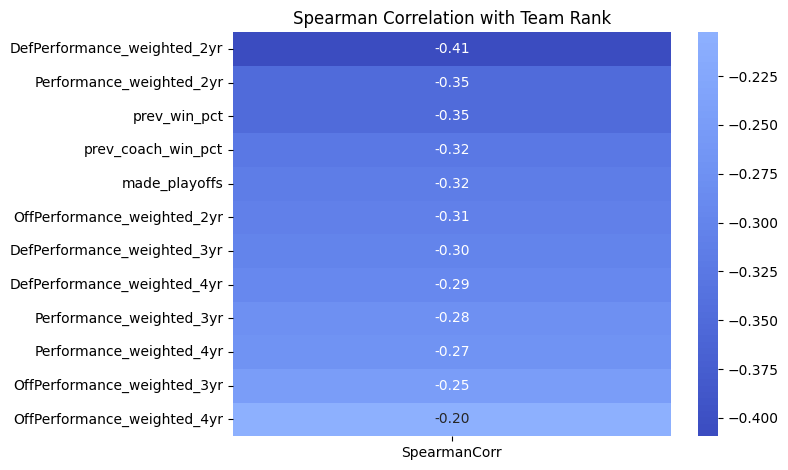

In [24]:
teams_df = sd.teams_df.copy()

# Adding teams data from Season 11
teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/teams.csv")[['year', 'tmID', 'confID']]

teams_df = pd.concat([teams_df, teams_year11_df], ignore_index=True)

players_teams_df=sd.players_teams_df.copy()

# Adding players data from Season 11
players_teams_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/players_teams.csv")[['playerID', 'year']]

players_teams_df = pd.concat([players_teams_df, players_teams_year11_df], ignore_index=True)

coaches_df=sd.coaches_df.copy()

# Adding coaches data from Season 11
coaches_year11_df = pd.read_csv("../basketballPlayoffs/Season_11/coaches.csv")

coaches_df = pd.concat([coaches_df, coaches_year11_df], ignore_index=True)

prepared_data = prepare_complete_dataset(
    teams_df,
    players_teams_df,
    coaches_df,
    output_file="../predict_datasets/teams.csv"
)

### Analysis of Spearman Correlation with Team Rank

1. **Target and Interpretation**  
   - The target variable is **team rank**, where a lower rank number indicates a better-performing team.  
   - **Negative correlation** indicates that higher feature values are associated with **better teams**.  

2. **Top Predictive Features**
   - **`DefPerformance_weighted_2yr` (-0.41):** The strongest predictor. Teams with higher defensive performance over the last 2 years tend to rank higher.  
   - **`Performance_weighted_2yr` (-0.35):** Overall performance over the last 2 years is also strongly associated with better team ranking.  
   - **`prev_win_pct` (-0.35):** Previous season’s win percentage is a key indicator of team strength.  
   - **`prev_coach_win_pct` (-0.32):** Teams with historically successful coaches tend to perform better.  

3. **Offensive vs Defensive Performance**
   - **Defensive metrics** generally have slightly stronger correlations with team rank than offensive metrics.  
   - Weighted defensive performance over 2 years (-0.41) is more predictive than 2-year offensive performance (-0.31).  

4. **Multi-Year Weighted Features**
   - Correlations tend to decrease slightly as the weighting window increases (e.g., 3-year and 4-year weighted features show weaker correlations than 2-year features).  
   - This suggests that more recent performance is more informative for predicting current team success.  

5. **Insights**
   - Team success is most strongly driven by **recent defensive performance**, overall recent performance, and the historical success of the coach and team.  
   - Offensive performance contributes positively but is slightly less predictive than defensive metrics.  
   - Using weighted historical features for 2 years captures the most relevant performance signal.


#### Idea For the Dataset Preparation

This dataset is built around team rankings. For each team, we calculate player scores based on their performance in previous seasons, and assign those scores to the team according to its roster at the start of the season.

Initially, we considered using only the overall player score. However, after further analysis, we decided to include separate offensive and defensive scores as well, since they showed a strong correlation with better team rankings.

We also incorporated the team’s win rate from the previous season, as well as the coach’s last year win rate, to account for both the team’s recent performance and the coach’s momentum.

Finally, we included playoff results from the prior season, as they reflect how well the team finished the year and whether it carried success into the postseason.